In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler

from torchsummaryX import summary
import timm
from torchvision import transforms as T
from torchmetrics.functional import accuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_roc
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import glob
import os

# Seed Random

In [2]:
torch.cuda.random.manual_seed(142)
torch.random.manual_seed(142)
np.random.seed(142)

# Load data

In [3]:
data = glob.glob('data/asl_alphabet_train/asl_alphabet_train/**/*.jpg')

In [4]:
labels = sorted([os.path.basename(folder_path) for folder_path in glob.glob('data/asl_alphabet_train/asl_alphabet_train/*')])
label_index = dict([(label, index) for index, label in enumerate(labels)])
index_label = dict([(index, label) for index, label in enumerate(labels)])

In [5]:
all_labels = [label_index[os.path.basename(os.path.dirname(dat))] for dat in data]

In [6]:
train_data, test_data, train_label, test_label = train_test_split(data, all_labels, stratify=all_labels, test_size=0.2, random_state=2021)

# Prepare data
- Using a transform module we can apply transformation
- Then we load it to the usual dataloader

In [7]:
train_transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [8]:
class HandSignDataset(Dataset):
    def __init__(self, image_path, label, transform):
        super(HandSignDataset, self).__init__()
        self.image_path = image_path
        self.label = label
        self.transform = transform
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, index):
        image_path = self.image_path[index]
        
        img = Image.open(image_path)
        return self.transform(img), torch.tensor(self.label[index])

In [9]:
train_dataset = HandSignDataset(train_data, train_label, train_transform)
test_dataset = HandSignDataset(test_data, test_label, test_transform)

In [10]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=16, num_workers=3)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16, num_workers=3)

# Create model
- Lets use the latest effnet v2 model
- We are gonna use timm model

In [11]:
class HandSignClassify(nn.Module):
    def __init__(self, num_classes=29, architecture='tf_efficientnetv2_b2'):
        super(HandSignClassify, self).__init__()
        self.base_model = timm.create_model(architecture, pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Linear(1408, 625),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(625, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

In [12]:
model = HandSignClassify()
model.to('cuda')

summary(model, torch.randn(1, 3, 224, 224).to('cuda'))

                                                        Kernel Shape  \
Layer                                                                  
0_base_model.Conv2dSame_conv_stem                      [3, 32, 3, 3]   
1_base_model.BatchNorm2d_bn1                                    [32]   
2_base_model.SiLU_act1                                             -   
3_base_model.blocks.0.0.Conv2d_conv                   [32, 16, 3, 3]   
4_base_model.blocks.0.0.BatchNorm2d_bn1                         [16]   
5_base_model.blocks.0.0.SiLU_act1                                  -   
6_base_model.blocks.0.1.Conv2d_conv                   [16, 16, 3, 3]   
7_base_model.blocks.0.1.BatchNorm2d_bn1                         [16]   
8_base_model.blocks.0.1.SiLU_act1                                  -   
9_base_model.blocks.1.0.Conv2dSame_conv_exp           [16, 64, 3, 3]   
10_base_model.blocks.1.0.BatchNorm2d_bn1                        [64]   
11_base_model.blocks.1.0.SiLU_act1                              

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_base_model.Conv2dSame_conv_stem,"[3, 32, 3, 3]","[1, 32, 112, 112]",864.0,10838016.0
1_base_model.BatchNorm2d_bn1,[32],"[1, 32, 112, 112]",64.0,32.0
2_base_model.SiLU_act1,-,"[1, 32, 112, 112]",NaN,NaN
3_base_model.blocks.0.0.Conv2d_conv,"[32, 16, 3, 3]","[1, 16, 112, 112]",4608.0,57802752.0
4_base_model.blocks.0.0.BatchNorm2d_bn1,[16],"[1, 16, 112, 112]",32.0,16.0
...,...,...,...,...
291_base_model.classifier.ReLU_1,-,"[1, 625]",NaN,NaN
292_base_model.classifier.Dropout_2,-,"[1, 625]",NaN,NaN
293_base_model.classifier.Linear_3,"[625, 256]","[1, 256]",160256.0,160000.0


In [13]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-8)

# Create training loop

In [14]:
for i in tqdm(range(2)):
    print('Running Epoch: {}'.format(i))
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    
    for index, (image, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        image = image.to('cuda')
        label = label.to('cuda')
        
        # Forward pass
        model.zero_grad()
        logits = model(image)
        
        loss = criterion(logits, label)
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        train_acc += accuracy(logits.argmax(axis=1), label)
        
    print('Training Loss: {}'.format(train_loss / len(train_dataloader)))
    print('Training Acc: {}'.format(train_acc / len(train_dataloader)))
    
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    
    for index, (test_image, test_labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        test_image = test_image.to('cuda')
        test_labels = test_labels.to('cuda')
        
        with torch.no_grad():
            logits = model(test_image)
        
        loss = criterion(logits, test_labels)
        
        valid_loss += loss.item()
        valid_acc += accuracy(logits.argmax(axis=1), test_labels)
        
    print('Test Loss: {}'.format(valid_loss / len(test_dataloader)))
    print('Test Acc: {}'.format(valid_acc / len(test_dataloader)))

Running Epoch: 0



Training Loss: 0.14877396522167868
Training Acc: 0.9625574946403503



Test Loss: 0.0026343058384538033
Test Acc: 0.9993106722831726
Running Epoch: 1



Training Loss: 0.012105521694557687
Training Acc: 0.9970114827156067



Test Loss: 0.0007138181114946437
Test Acc: 1.0



# Model Evaluation

In [15]:
preds = []

for image, label in tqdm(test_dataloader):
    with torch.no_grad():
        logits = model(image.to('cuda'))
        
    preds.append(logits.detach().cpu().numpy())

preds = np.concatenate(preds)

In [16]:
print(classification_report(test_label, preds.argmax(axis=1), target_names=labels))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       600
           B       1.00      1.00      1.00       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       1.00      1.00      1.00       600
           F       1.00      1.00      1.00       600
           G       1.00      1.00      1.00       600
           H       1.00      1.00      1.00       600
           I       1.00      1.00      1.00       600
           J       1.00      1.00      1.00       600
           K       1.00      1.00      1.00       600
           L       1.00      1.00      1.00       600
           M       1.00      1.00      1.00       600
           N       1.00      1.00      1.00       600
           O       1.00      1.00      1.00       600
           P       1.00      1.00      1.00       600
           Q       1.00      1.00      1.00       600
           R       1.00    

In [17]:
print('MCC: {}'.format(round(matthews_corrcoef(test_label, preds.argmax(axis=1)) * 100, 2)))

MCC: 100.0


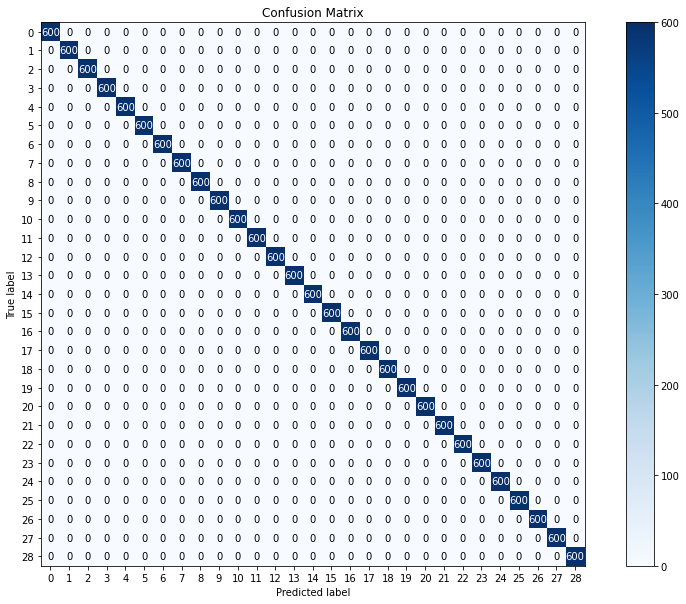

In [18]:
plot_confusion_matrix(test_label, preds.argmax(axis=1), figsize=(15, 10));

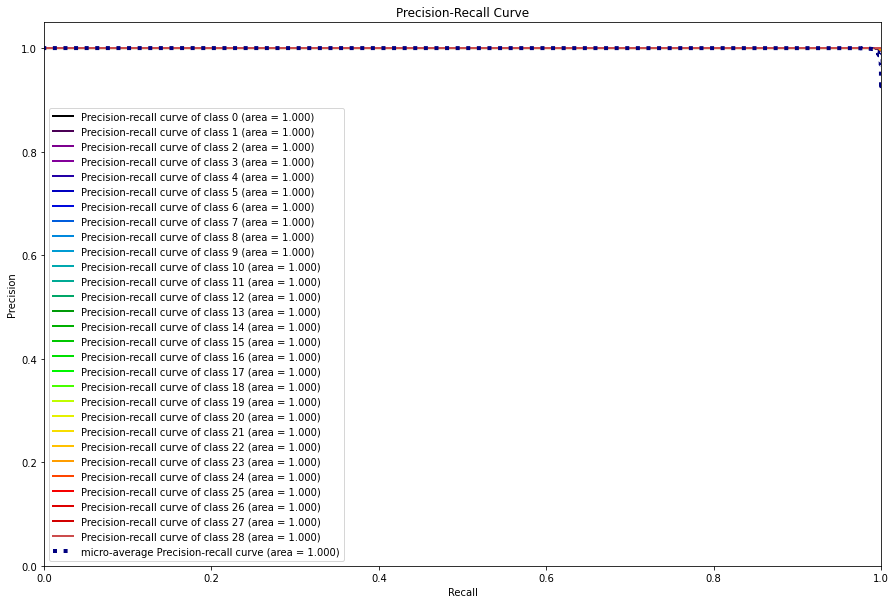

In [19]:
plot_precision_recall(test_label, preds, figsize=(15, 10));

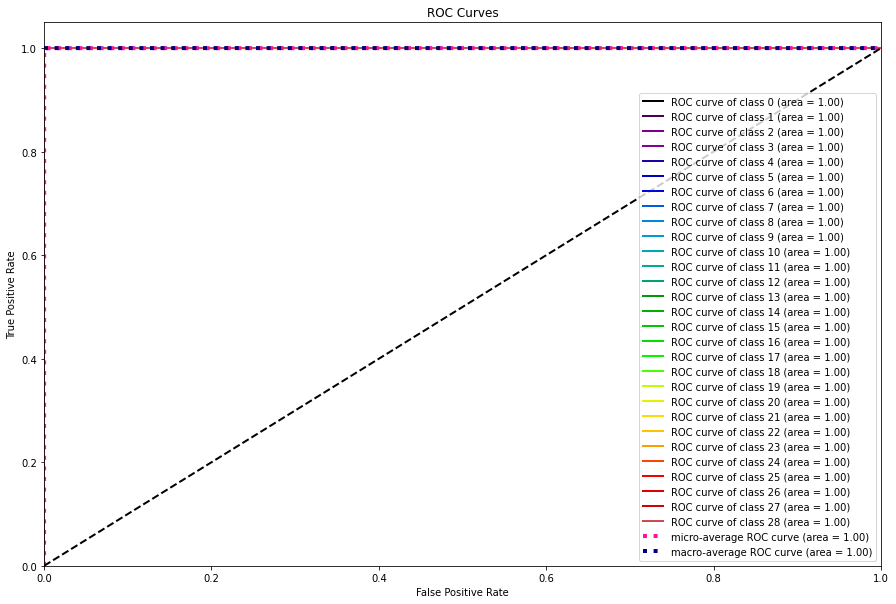

In [20]:
plot_roc(test_label, preds, figsize=(15, 10));

# Save model

In [22]:
os.makedirs('weights', exist_ok=True)
torch.save(model.state_dict(), 'weights/effnet_v2_b2.pth')